# NN Model 0

- V0 Based on HyperOpt optimizated model
    - including extra features increased CV score, but lowered LB score
    - including isChinese features increase LB score slightly

Validation scores:
- V0: CV: 2.3919 / LB: 2.38810

In [67]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import time
import sys

#import sys
#import pymongo
#import bson.objectid
#pymongo.objectid = bson.objectid
#sys.modules["pymongo.objectid"] = bson.objectid

#os.environ['KERAS_BACKEND']='tensorflow'
#os.environ['THEANO_FLAGS'] = 'device=cpu'
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import Callback
import keras

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import log_loss
import pickle

In [68]:
dir_in = 'data_ori'
dir_feat = 'data'
rs = 123
fixed_seed_num = 1234
np.random.seed(fixed_seed_num)
random.seed(fixed_seed_num) # not sure if needed or not

feature_files_old = ['features_bag_brand',
                 'features_bag_model',
                'features_bag_label_installed',
                'features_bag_app_installed']
feature_files = ['features_brand_bag',
                 'features_brand_model_bag',
                 'features_brand_model.csv']
feature_files=feature_files[0:3]

# Function to read feature file
def open_feature_file(fname, samples='train'):
    if fname[-3:] == 'csv':
        if samples=='train':
            X = gatrain[['device_id']].merge( pd.read_csv(os.path.join(dir_feat, fname)), on='device_id', how='left')
        else:
            X = gatest[['device_id']].merge( pd.read_csv(os.path.join(dir_feat, fname)), on='device_id', how='left')
            
        X.drop('device_id', axis=1, inplace=True)
        X.fillna(0, inplace=True)
        
        for c in X.columns:
            if X[c].max()>1:
                X[c] = StandardScaler().fit_transform(X)
                
        return csr_matrix(X.values)
    else:
        # Assume it is a pickle file
        with open(os.path.join(dir_feat, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
            return pickle.load(f)

In [69]:
# Calculate CV score on Xtrain, y
def score(X, clf = None, random_state = 123, w = None):
    if not clf: clf = LogisticRegression(C=0.13, multi_class='multinomial',solver='lbfgs', n_jobs=2)
        
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = X[itrain, :], X[itest, :]
        ytr, yte = y[itrain], y[itest]
        if np.any(w):
            ws = w[itrain]
        else:
            ws = None
            
        clf.fit(Xtr, ytr, sample_weight = ws)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    #print('')
    return log_loss(y, pred)

## Get basescore on installed bag of apps

In [70]:
gatrain = pd.read_csv(os.path.join(dir_in,'gender_age_train.csv'))
gatest = pd.read_csv(os.path.join(dir_in,'gender_age_test.csv'))
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [71]:
fw = [1, 1, 1, 1]
Xtrain = hstack([open_feature_file(f) for f in feature_files],format='csr')
Xtest = hstack([open_feature_file(f,'test') for f in feature_files],format='csr')

In [72]:
Xtrain = Xtrain[:, 0:1800]
Xtest = Xtest[:, 0:1800]

In [73]:
print('Training on {} features'.format(Xtrain.shape[1]))
basescore = score(Xtrain, random_state=rs)
print('Basescore: {:.5f}'.format(basescore))

Training on 1800 features
Basescore: 2.39188


## Get score and train and test

In [74]:
def nn_model1(X, params):
    
    # create model
    print ('NN model with following params: %s' % (params))
    
    model = Sequential()
    model.add(Dense(params['layer_1']['units1'], 
                    input_dim=X.shape[1], 
                    init='normal', 
                    activation=params['layer_1']['activation1']))
    
    model.add(Dropout(params['layer_1']['dropout1']))
    
    if params['layer_2']['on2']:
        model.add(Dense(params['layer_2']['units2'], 
                        input_dim=X.shape[1], 
                        init='normal', 
                        activation=params['layer_2']['activation2']))
        #https://www.kaggle.com/poiss0nriot/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/run/328610
        #model.add(PReLU())
        model.add(Dropout(params['layer_2']['dropout2']))
    
    if params['layer_3']['on3']:
        model.add(Dense(params['layer_3']['units3'], 
                        init='normal', 
                        activation=params['layer_3']['activation3']))
        
        model.add(Dropout(params['layer_3']['dropout3']))
    
    model.add(Dense(12, init='normal', activation='softmax'))    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])  #logloss
    
    return model

In [79]:
params = {'optimizer': 'adam',
          'batch_size': 32,
          'n_epoch': 4,
         'layer_1': {'on1': True,
                     'units1': 150,
                     'activation1': 'tanh',
                     'dropout1': 0.8},
         'layer_2': {'on2': False,
                    'units2': 150,
                    'activation2': 'tanh',
                    'dropout2': 0.2},
          'layer_3': {'on3': False,
                     'units3': 12,
                     'activation3': 'sigmoid',
                     'dropout3': 0.2}
          }

In [80]:
kf = list(StratifiedKFold(y, n_folds=10, shuffle=True, random_state=4242))[0]

Xtr, Xte = Xtrain[kf[0], :], Xtrain[kf[1], :]
ytr, yte = y[kf[0]], y[kf[1]]

print('Training set: ' + str(Xtr.shape))
print('Validation set: ' + str(Xte.shape))

model=nn_model1(Xtr, params)

fit=model.fit(Xtr.todense(), 
              np_utils.to_categorical(ytr), 
              nb_epoch = params['n_epoch'], 
              batch_size=params['batch_size'],
              validation_data=(Xte.todense(), np_utils.to_categorical(yte)), 
              verbose=2)

scores_val = model.predict_proba(Xte.todense(), batch_size = 128, verbose = 0)
print('Validation score:',log_loss(yte, scores_val))

Training set: (67176, 1800)
Validation set: (7469, 1800)
NN model with following params: {'optimizer': 'adam', 'layer_1': {'units1': 150, 'activation1': 'tanh', 'on1': True, 'dropout1': 0.8}, 'layer_3': {'activation3': 'sigmoid', 'on3': False, 'units3': 12, 'dropout3': 0.2}, 'layer_2': {'on2': False, 'activation2': 'tanh', 'units2': 150, 'dropout2': 0.2}, 'batch_size': 32, 'n_epoch': 4}
Train on 67176 samples, validate on 7469 samples
Epoch 1/4
11s - loss: 2.4172 - acc: 0.1392 - val_loss: 2.3953 - val_acc: 0.1521
Epoch 2/4
21s - loss: 2.3972 - acc: 0.1515 - val_loss: 2.3922 - val_acc: 0.1509
Epoch 3/4
24s - loss: 2.3898 - acc: 0.1561 - val_loss: 2.3906 - val_acc: 0.1540
Epoch 4/4
26s - loss: 2.3839 - acc: 0.1587 - val_loss: 2.3920 - val_acc: 0.1553
('Validation score:', 2.3920245206185271)


In [81]:
pred = model.predict_proba(Xtest.todense())
pred = pd.DataFrame(pred, index = gatest.device_id, columns=targetencoder.classes_)
pred.head()
pred.to_csv('model_0_nn.csv', index=True)

111872/112071 [============================>.] - ETA: 0s

## Test Keras model

In [7]:
dummy_y = np_utils.to_categorical(y)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(Xtrain, dummy_y, stratify=y,
                                                  test_size=0.1, random_state=42)

In [28]:
def batch_generator(X, y, batch_size, shuffle):
    #chenglong code for fiting from generator (https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices)
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch, np.ones(X_batch.shape[0])
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch#, np.ones(X_batch.shape[0])
        if (counter == number_of_batches):
            counter = 0

# Best model:
# With layer1: 2.38222170278
# With layer2: 2.3828 ('activation2': 1, 'units2': 141.67406062812924, 'n_epoch': 6.1304111628793283, 'dropout2': 0.54756289671556369)
params = {'optimizer': 'adam',
          'batch_size': 32,
          'n_epoch': 5,
         'layer_1': {'on1': True,
                     'units1': 150,
                     'activation1': 'tanh',
                     'dropout1': 0.8},
         'layer_2': {'on2': False,
                    'units2': 150,
                    'activation2': 'tanh',
                    'dropout2': 0.2},
          'layer_3': {'on3': False,
                     'units3': 12,
                     'activation3': 'sigmoid',
                     'dropout3': 0.2}
          }

# define baseline model
params = {'optimizer': 'adam',
          'batch_size': 32, #hp.uniform('batch_size', 16, 512),
          'n_epoch': hp.uniform('n_epoch', 3, 7),
         'layer_1': {'on1': True,
                     'units1': 150,
                     'activation1': 'tanh',
                     'dropout1': 0.8},
         'layer_2': {'on2': True,
                    'units2': hp.uniform('units2', 16, 256),
                    'activation2': hp.choice('activation2',['relu','tanh']),
                    'dropout2': hp.uniform('dropout2', .2, .9)},
          'layer_3': {'on3': False,
                     'units3': 16,
                     'activation3': 'relu',
                     'dropout3': .25}
          }


def f_nn(params):
    global counter
    global times
    
    a = time.time()
    
    # create model
    print ('Params testing %d: %s' % (counter, params))
    counter += 1
    
    model = Sequential()
    model.add(Dense(params['layer_1']['units1'], 
                    input_dim=Xtrain.shape[1], 
                    init='normal', 
                    activation=params['layer_1']['activation1']))
    
    model.add(Dropout(params['layer_1']['dropout1']))
    
    if params['layer_2']['on2']:
        model.add(Dense(params['layer_2']['units2'], 
                        input_dim=Xtrain.shape[1], 
                        init='normal', 
                        activation=params['layer_2']['activation2']))
        #https://www.kaggle.com/poiss0nriot/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/run/328610
        #model.add(PReLU())
        model.add(Dropout(params['layer_2']['dropout2']))
    
    if params['layer_3']['on3']:
        model.add(Dense(params['layer_3']['units3'], 
                        init='normal', 
                        activation=params['layer_3']['activation3']))
        
        model.add(Dropout(params['layer_3']['dropout3']))
    
    model.add(Dense(12, init='normal', activation='softmax'))    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])  #logloss
    
    hist_all = prediction_hist('test')
    
    fit=model.fit(X_train.todense(), y_train, nb_epoch = int(params['n_epoch']), batch_size=int(params['batch_size']),
                             validation_data=(X_val.todense(), y_val), verbose=2,
                 callbacks=[hist_all]) 
    
    scores_val = model.predict_proba(X_val.todense(), batch_size = 128, verbose = 0)

    logloss = log_loss(y_val, scores_val)
    times.append(a-time.time())
                        
    print('Log_loss:', logloss, 'It took', a-time.time())
    print('Average time per eval:', sum(times)/counter)
    sys.stdout.flush() 
    return {'loss': logloss, 'status': STATUS_OK}

def plot_loss_progress(pred_hist_obj, ax1=None, ax2=None, c='g'):
    
    df = pred_hist_obj.predhist
    
    if not ax1:
        fig, (ax1, ax2) = plt.subplot(1, 2, figsize=(16,4))
        
    df.plot(y='acc', ax=ax1, label=pred_hist_obj.tag, color=c)
    df.plot(y='val_acc', ax=ax1, label=pred_hist_obj.tag, linestyle='--', color=c)
    ax1.set_title('Accuracy score')
    ax1.set_xlabel('Epoch #')
    ax1.set_ylabel('Accuracy')
    
    df.plot(y='logloss', ax=ax2, label=pred_hist_obj.tag, color=c)
    df.plot(y='val_logloss', ax=ax2, label=pred_hist_obj.tag, linestyle='--', color=c)
    ax2.set_title('Logloss score')
    ax2.set_xlabel('Epoch #')
    ax2.set_ylabel('Logloss')

class prediction_hist(Callback):
    def __init__(self, tag=''):
        self.predhist = pd.DataFrame(columns=['acc','logloss','val_acc','val_logloss'])
        self.tag = str(tag)
        
    def on_epoch_end(self, epoch, logs={}):
        #print logs.values()
        self.predhist.loc[epoch] = logs.values()
        

In [29]:
counter = 0
times = []
trials = Trials()
best = fmin(f_nn, params, algo=tpe.suggest, max_evals=300, trials=trials)
print 'best: '
print best


Params testing 0: {'n_epoch': 4.144557339801517, 'optimizer': 'adam', 'layer_1': {'units1': 150, 'activation1': 'tanh', 'on1': True, 'dropout1': 0.8}, 'layer_3': {'activation3': 'relu', 'on3': False, 'units3': 16, 'dropout3': 0.25}, 'layer_2': {'on2': True, 'activation2': 'relu', 'units2': 183.1526045434868, 'dropout2': 0.35879601749494217}, 'batch_size': 32}
Train on 67179 samples, validate on 7466 samples
Epoch 1/4
16s - loss: 2.4164 - acc: 0.1408 - val_loss: 2.3972 - val_acc: 0.1540
Epoch 2/4
26s - loss: 2.4046 - acc: 0.1477 - val_loss: 2.3987 - val_acc: 0.1585
Epoch 3/4
29s - loss: 2.3992 - acc: 0.1499 - val_loss: 2.3933 - val_acc: 0.1543
Epoch 4/4
32s - loss: 2.3952 - acc: 0.1541 - val_loss: 2.3908 - val_acc: 0.1538
('Log_loss:', 2.3908073852472898, 'It took', -114.80944800376892)
('Average time per eval:', -114.80944609642029)
Params testing 1: {'n_epoch': 5.981885939542452, 'optimizer': 'adam', 'layer_1': {'units1': 150, 'activation1': 'tanh', 'on1': True, 'dropout1': 0.8}, 'lay

0 n_epoch 2.41001885903
1 activation2 2.41001885903
2 units2 2.41001885903
3 dropout2 2.41001885903
{'activation2': 1, 'units2': 141.67406062812924, 'n_epoch': 6.1304111628793283, 'dropout2': 0.54756289671556369}


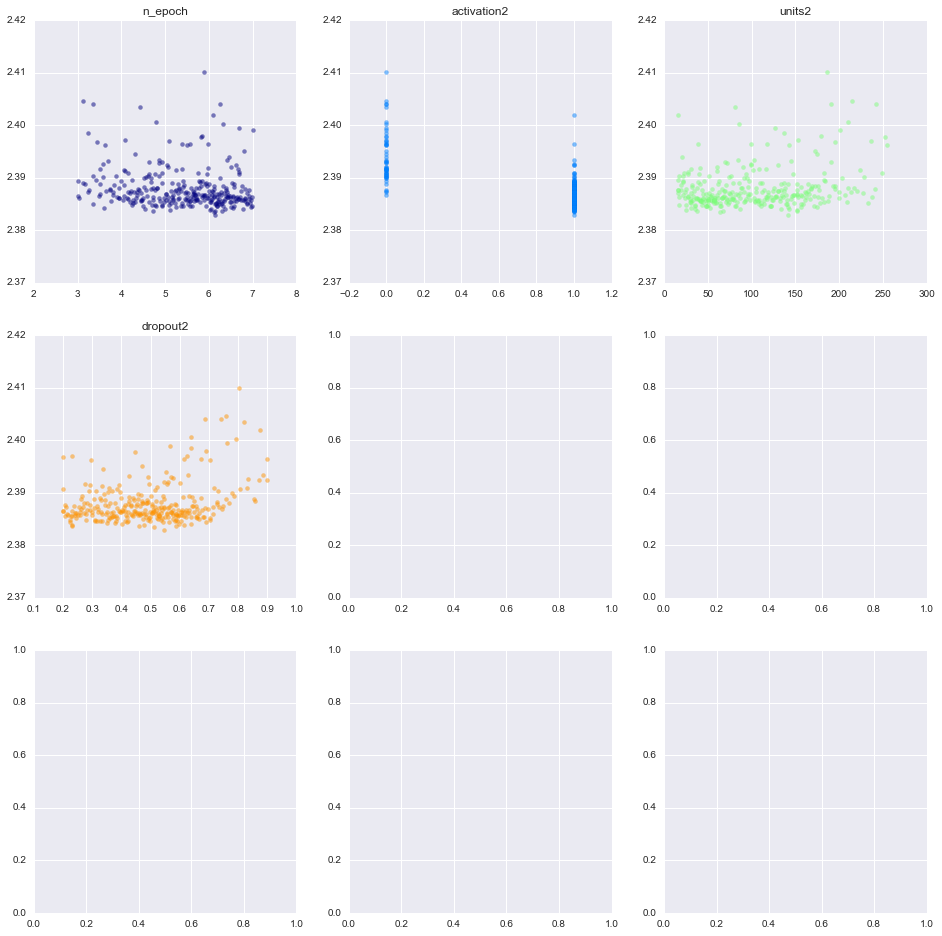

In [30]:
parameters = trials.trials[0]['misc']['vals'].keys()
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
cmap = plt.cm.jet
par_best_score = {}
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials if 'loss' in t['result']]).ravel()
    ys = [t['result']['loss'] for t in trials.trials if 'loss' in t['result']]
    
    par_best_score[val] = xs[ys.index(min(ys))]
    #print trials.trials[ys.index(max(ys))]
    print i, val, max(ys)
    #xs, ys = zip(sorted(xs), sorted(ys))
    #ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)
print par_best_score

0 n_epoch 2.38285702477
1 activation2 2.38285702477
2 units2 2.38285702477
3 dropout2 2.38285702477
{}


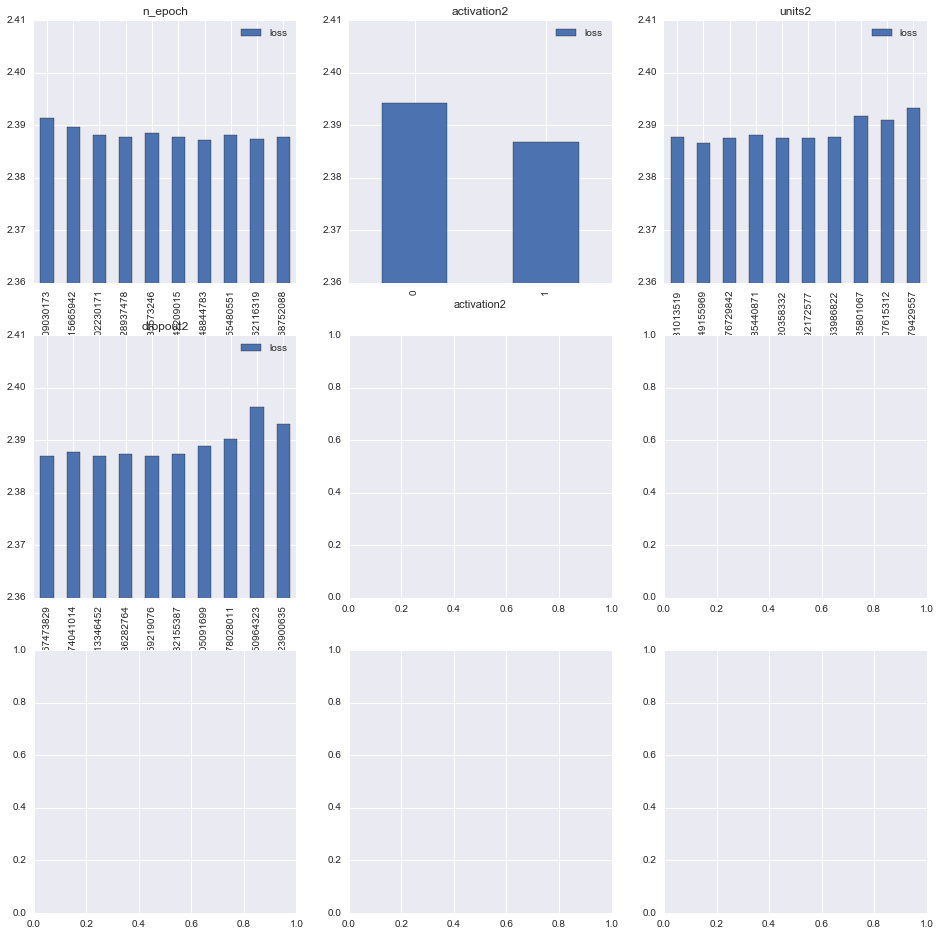

In [31]:
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
cmap = plt.cm.jet
par_best_score = {}
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials if 'loss' in t['result']]).ravel()
    ys = [t['result']['loss'] for t in trials.trials if 'loss' in t['result']]
    
    #par_best_score[val] = xs[ys.index(max(ys))]
    #print trials.trials[ys.index(max(ys))]
    print i, val, min(ys)
    #xs, ys = zip(sorted(xs), sorted(ys))
    #ys = np.array(ys)
    a=pd.DataFrame({val:xs,'loss':ys})
    
    if a[val].nunique()>10:
        a[val] = pd.cut(a[val], 10, labels=np.linspace(a[val].min(),a[val].max(),10))
    #a[val] = a[val].round(0)
    (a.groupby(val).agg('mean')).plot(kind='bar',ylim=[2.36, 2.41], ax=axes[i/3,i%3])
    axes[i/3,i%3].set_title(val)
print par_best_score

In [ ]:
x = [1, 1.2, 1.23, 1.3, 1.56]
bins=np.linspace(min(x),max(x),10)
a=pd.Series(x)
pd.cut(a, 10, labels=bins)

In [ ]:
a=pd.DataFrame({'activation2':xs,'loss':ys})
a.sample(10)

In [ ]:
(a.groupby('activation2').agg('mean')).plot(kind='bar', xlim=[-2.38, -2.42])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
drs = [0.1, 0.2, 0.3, 0.4, 0.5]
optim = ['adamax', 'adam', 'nadam', 'adadelta']
cs = 'grbycm'
for i,dr in enumerate(optim):
    hist_all = prediction_hist(tag=optim)
    
    model=baseline_model(params)
    
    fit=model.fit(X_train.todense(), y_train, nb_epoch = 7, batch_size=32,
                             validation_data=(X_val.todense(), y_val), verbose=2,
                 callbacks=[hist_all]) 
    
    plot_loss_progress(hist_all, ax1=ax1, ax2=ax2, c=cs[i])

In [ ]:
model.summary()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

cs = 'grbycm'
plot_loss_progress(hist_all, ax1=ax1, ax2=ax2, c=cs[i])

In [ ]:
print hist_generator.predhist.head()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
plot_loss_progress(hist_all, ax1=ax1, ax2=ax2)

In [ ]:
# evaluate the model
scores_val = model.predict_generator(generator=batch_generatorp(X_val, 32, False), val_samples=X_val.shape[0])
scores = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])

print('logloss val {}'.format(log_loss(y_val, scores_val)))

In [ ]:
basescore = 2.27506319419 (2.2751433925) with weight in batch_generator: 2.2751433925, 2.2751433925

In [ ]:
pred = pd.DataFrame(scores, index = gatest['device_id'], columns=targetencoder.classes_)
pred.to_csv('A_keras_model_on_apps_and_labels.csv',index=True)

## Fit on complete model

In [ ]:
model=baseline_model()
fit=model.fit(X_train.todense(), y_train, nb_epoch = 20, batch_size=32,
                         validation_data=(X_val.todense(), y_val), verbose=2)

In [ ]:
# evaluate the model
scores_val = model.predict_generator(generator=batch_generatorp(X_val, 32, False), val_samples=X_val.shape[0])
print('logloss val {}'.format(log_loss(y_val, scores_val)))

In [ ]:
model.summary()